# Exploratory data analysis with the Alibaba dataset

In this notebook, we attempt in understanding how groundtruth cluster profiles, based on metadata values, would look like.
To understand them, we evaluate how well the points fit in the groups, using the _silhouette_ measure.

In [1]:
import pandas as pd
import numpy as np

In [2]:
from dask.delayed import delayed
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.preprocessing import StandardScaler

In [ ]:
 from scipy.stats import norm
import numpy as np

import matplotlib as mpl
from cycler import cycler
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [82]:
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

In [199]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import normalize
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import OneHotEncoder
from scipy.special import softmax

In [8]:
import hdbscan
from sklearn.cluster import OPTICS

In [9]:
from collections import defaultdict
from collections import Counter

In [10]:
import random

In [11]:
import sys
import logging

nblog = open("nb.log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


### Define functions

In [12]:
def plot_silhouette_results(cluster_labels, silhouette_avg, sample_silhouette_values, n_clusters, multiplier=10000, le_name_mapping=None):
    plt.figure(figsize=(12, 12))

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    plt.xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    #plt.ylim([0, len(scaled) + (n_clusters + 1) * 10])

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i 

        color = cm.nipy_spectral(float(i) / n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        if le_name_mapping:
            plt.text(-0.05, y_lower + 0.5 * size_cluster_i, le_name_mapping[i])
        else:
            # Label the silhouette plots with their cluster numbers at the middle
            plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + multiplier  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks([-1., -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [13]:
def load_dd_delayed(keyword):
    with open('/data/clusterdata/cluster-trace-gpu-v2020/data/pai_%s.header' % keyword) as fin:
        lines = fin.readlines()
        col_names = lines[0].strip().split(',')

    col_names

    dfs = delayed(pd.read_csv)('/data/clusterdata/cluster-trace-gpu-v2020/data/pai_%s.tar.gz' % keyword, 
                               header=None, index_col=False, names=col_names, delimiter=',')

    dd_delayed = dd.from_delayed(dfs)

    return dd_delayed

In [14]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [15]:
def stratified_proportional_sampling(dataframe_in, filter_metric, filter_values, sampling_perc):
    target_vals = []
    for val in filter_values:
        val_array = dataframe_in[dataframe_in[filter_metric] == val].select_dtypes(include=np.number).fillna(0).values
        target_vals = target_vals + random.sample(list(val_array), int(val_array.shape[0] * sampling_perc))
    return target_vals

In [16]:
def stratified_sample(df, strata, size=None, seed=None, keep_index= True):
    '''
    It samples data from a pandas dataframe using strata. These functions use
    proportionate stratification:
    n1 = (N1/N) * n
    where:
        - n1 is the sample size of stratum 1
        - N1 is the population size of stratum 1
        - N is the total population size
        - n is the sampling size
    Parameters
    ----------
    :df: pandas dataframe from which data will be sampled.
    :strata: list containing columns that will be used in the stratified sampling.
    :size: sampling size. If not informed, a sampling size will be calculated
        using Cochran adjusted sampling formula:
        cochran_n = (Z**2 * p * q) /e**2
        where:
            - Z is the z-value. In this case we use 1.96 representing 95%
            - p is the estimated proportion of the population which has an
                attribute. In this case we use 0.5
            - q is 1-p
            - e is the margin of error
        This formula is adjusted as follows:
        adjusted_cochran = cochran_n / 1+((cochran_n -1)/N)
        where:
            - cochran_n = result of the previous formula
            - N is the population size
    :seed: sampling seed
    :keep_index: if True, it keeps a column with the original population index indicator
    
    Returns
    -------
    A sampled pandas dataframe based in a set of strata.
    Examples
    --------
    >> df.head()
    	id  sex age city 
    0	123 M   20  XYZ
    1	456 M   25  XYZ
    2	789 M   21  YZX
    3	987 F   40  ZXY
    4	654 M   45  ZXY
    ...
    # This returns a sample stratified by sex and city containing 30% of the size of
    # the original data
    >> stratified = stratified_sample(df=df, strata=['sex', 'city'], size=0.3)
    Requirements
    ------------
    - pandas
    - numpy
    '''
    population = len(df)
    size = __smpl_size(population, size)
    tmp = df[strata]
    tmp['size'] = 1
    tmp_grpd = tmp.groupby(strata).count().reset_index()
    tmp_grpd['samp_size'] = round(size/population * tmp_grpd['size']).astype(int)

    # controlling variable to create the dataframe or append to it
    first = True 
    for i in range(len(tmp_grpd)):
        # query generator for each iteration
        qry=''
        for s in range(len(strata)):
            stratum = strata[s]
            value = tmp_grpd.iloc[i][stratum]
            n = tmp_grpd.iloc[i]['samp_size']

            if type(value) == str:
                value = "'" + str(value) + "'"
            
            if s != len(strata)-1:
                qry = qry + stratum + ' == ' + str(value) +' & '
            else:
                qry = qry + stratum + ' == ' + str(value)
        
        # final dataframe
        if first:
            stratified_df = df.query(qry).sample(n=n, random_state=seed).reset_index(drop=(not keep_index))
            first = False
        else:
            tmp_df = df.query(qry).sample(n=n, random_state=seed).reset_index(drop=(not keep_index))
            stratified_df = stratified_df.append(tmp_df, ignore_index=True)
    
    return stratified_df



def stratified_sample_report(df, strata, size=None):
    '''
    Generates a dataframe reporting the counts in each stratum and the counts
    for the final sampled dataframe.
    Parameters
    ----------
    :df: pandas dataframe from which data will be sampled.
    :strata: list containing columns that will be used in the stratified sampling.
    :size: sampling size. If not informed, a sampling size will be calculated
        using Cochran adjusted sampling formula:
        cochran_n = (Z**2 * p * q) /e**2
        where:
            - Z is the z-value. In this case we use 1.96 representing 95%
            - p is the estimated proportion of the population which has an
                attribute. In this case we use 0.5
            - q is 1-p
            - e is the margin of error
        This formula is adjusted as follows:
        adjusted_cochran = cochran_n / 1+((cochran_n -1)/N)
        where:
            - cochran_n = result of the previous formula
            - N is the population size
    Returns
    -------
    A dataframe reporting the counts in each stratum and the counts
    for the final sampled dataframe.
    '''
    population = len(df)
    size = __smpl_size(population, size)
    tmp = df[strata]
    tmp['size'] = 1
    tmp_grpd = tmp.groupby(strata).count().reset_index()
    tmp_grpd['samp_size'] = round(size/population * tmp_grpd['size']).astype(int)
    return tmp_grpd


def __smpl_size(population, size):
    '''
    A function to compute the sample size. If not informed, a sampling 
    size will be calculated using Cochran adjusted sampling formula:
        cochran_n = (Z**2 * p * q) /e**2
        where:
            - Z is the z-value. In this case we use 1.96 representing 95%
            - p is the estimated proportion of the population which has an
                attribute. In this case we use 0.5
            - q is 1-p
            - e is the margin of error
        This formula is adjusted as follows:
        adjusted_cochran = cochran_n / 1+((cochran_n -1)/N)
        where:
            - cochran_n = result of the previous formula
            - N is the population size
    Parameters
    ----------
        :population: population size
        :size: sample size (default = None)
    Returns
    -------
    Calculated sample size to be used in the functions:
        - stratified_sample
        - stratified_sample_report
    '''
    if size is None:
        cochran_n = round(((1.96)**2 * 0.5 * 0.5)/ 0.02**2)
        n = round(cochran_n/(1+((cochran_n -1) /population)))
    elif size >= 0 and size < 1:
        n = round(population * size)
    elif size < 0:
        raise ValueError('Parameter "size" must be an integer or a proportion between 0 and 0.99.')
    elif size >= 1:
        n = size
    return n

## Data Extraction

In [17]:
dd_delayed = load_dd_delayed('job_table')

In [18]:
job_df = dd_delayed.compute()

In [19]:
job_df

,job_name,inst_id,user,status,start_time,end_time
0,pai_job_table.csv,38e2d7187762a9241cc1cd5732dbe52a5d8b37ed7dafe1...,74238accb90b,Running,1053513.0,NaN
1,9605ac7cc4c55a193fbe956b,e1cbdf28400847d65d00da4f0522ce7a43275fe9cb5d2a...,61d6b6dd5b15,Running,1097614.0,NaN
2,a2d8872d080eb634a42ea9a6,27ddabc2f7490279c6d5bd95c8a75e5c96d841c6030659...,61d6b6dd5b15,Running,1103820.0,NaN
3,e8baa72bfcd1b723cafab26a,70e4f598c8cdf40f24e0e7d3aba9a9dacde5342e1f2ffd...,61d6b6dd5b15,Terminated,1104396.0,1140852.0
4,4e87f469c73e13613908b658,5bb3500e7f1a42a9ce82544dad5f202547848e9727e221...,61d6b6dd5b15,Terminated,1109911.0,1233527.0
...,...,...,...,...,...,...
1055497,a155d69dca6bfd2dfb78ef0d,267c02fbda06c42fb83fc8034d2be1c51149127deb2292...,a4187a15253d,Terminated,6420116.0,6431658.0
1055498,e4e802c3b63829c1e2e3343b,37c6523c16f1574055fb637a82bb22a913122d58c8368a...,a4187a15253d,Running,6431847.0,NaN
1055499,f11820cc3d678bcdc37faf08,d50242c89f3a25bd20ef700701777823c415ad0321dcb3...,a4187a15253d,Terminated,6431859.0,6431872.0
1055500,ee3480523c1bf79b0d02c260,6c6338d4ac59fd1157e569fd6b5de6b70975c65112e9ba...,a4187a15253d,Terminated,6431969.0,6435635.0


In [20]:
job_df.value_counts('status')

status
Terminated    732355
Failed        256555
Running        62928
Waiting         3663
dtype: int64

In [21]:
dd_delayed = load_dd_delayed('task_table')

In [22]:
task_df = dd_delayed.compute()

In [23]:
task_df[task_df.job_name == 'f11820cc3d678bcdc37faf08']

,job_name,task_name,inst_num,status,start_time,end_time,plan_cpu,plan_mem,plan_gpu,gpu_type
840157,f11820cc3d678bcdc37faf08,PyTorchWorker,1.0,Terminated,6431859.0,6431872.0,1800.0,58.59375,100.0,MISC


In [24]:
job_result_df = pd.merge(job_df[['job_name', 'inst_id', 'user']], task_df, on='job_name', how='inner')

In [25]:
job_result_df

,job_name,inst_id,user,task_name,inst_num,status,start_time,end_time,plan_cpu,plan_mem,plan_gpu,gpu_type
0,9605ac7cc4c55a193fbe956b,e1cbdf28400847d65d00da4f0522ce7a43275fe9cb5d2a...,61d6b6dd5b15,worker,20.0,Running,1097614.0,NaN,NaN,NaN,NaN,P100
1,a2d8872d080eb634a42ea9a6,27ddabc2f7490279c6d5bd95c8a75e5c96d841c6030659...,61d6b6dd5b15,worker,100.0,Running,1103820.0,NaN,NaN,NaN,NaN,P100
2,e8baa72bfcd1b723cafab26a,70e4f598c8cdf40f24e0e7d3aba9a9dacde5342e1f2ffd...,61d6b6dd5b15,worker,20.0,Terminated,1104396.0,1140852.0,600.0,29.296875,50.0,MISC
3,4e87f469c73e13613908b658,5bb3500e7f1a42a9ce82544dad5f202547848e9727e221...,61d6b6dd5b15,worker,30.0,Terminated,1109911.0,1233527.0,600.0,29.296875,50.0,MISC
4,dcf1bd23bb296a8efb35902b,4fe3a2e132a1ffd068bf3d6dca3906d24a37f95df2c98e...,61d6b6dd5b15,worker,5.0,Terminated,1129126.0,1129627.0,600.0,29.296875,100.0,MISC
...,...,...,...,...,...,...,...,...,...,...,...,...
1261044,a155d69dca6bfd2dfb78ef0d,267c02fbda06c42fb83fc8034d2be1c51149127deb2292...,a4187a15253d,JupyterTask,1.0,Terminated,6420116.0,6431658.0,200.0,3.925781,100.0,MISC
1261045,e4e802c3b63829c1e2e3343b,37c6523c16f1574055fb637a82bb22a913122d58c8368a...,a4187a15253d,PyTorchWorker,1.0,Running,6431847.0,NaN,NaN,NaN,NaN,NaN
1261046,f11820cc3d678bcdc37faf08,d50242c89f3a25bd20ef700701777823c415ad0321dcb3...,a4187a15253d,PyTorchWorker,1.0,Terminated,6431859.0,6431872.0,1800.0,58.593750,100.0,MISC
1261047,ee3480523c1bf79b0d02c260,6c6338d4ac59fd1157e569fd6b5de6b70975c65112e9ba...,a4187a15253d,JupyterTask,1.0,Terminated,6431969.0,6435635.0,200.0,3.925781,100.0,MISC


In [26]:
job_result_df.value_counts('gpu_type')

gpu_type
MISC       696280
T4         226923
P100        72731
V100        28797
V100M32     18579
dtype: int64

In [27]:
dd_delayed = load_dd_delayed('group_tag_table')

In [28]:
group_tag_table_df = dd_delayed.compute()

In [29]:
group_tag_table_df

,inst_id,user,gpu_type_spec,group,workload
0,pai_group_tag_table.csv,58540f191766,NaN,ba4e3be6472ded359f4b1ca53d9bd53e,NaN
1,a8c39faded8b9a5b7436a47aff747835795cec39ef33c7...,58540f191766,NaN,81b1eed4c4b0463b7e5a154f7c42db1e,NaN
2,26bf18df11f3a989fa64ed808dc780ab24a7700941f7c1...,58540f191766,NaN,046437ed700bdf7434aa88503cc97a8d,NaN
3,a4fdd0229b8fcc227a8828daaa37500a29e125c1c38d1c...,58540f191766,NaN,d50ee406f93d51ccf485b415861dd8f5,NaN
4,4b4ab6c2a0691b35d8a9abb22ade8164b6be1bdb19c8a7...,58540f191766,NaN,c5ee81877b36fdb5dac829aab7b4146a,NaN
...,...,...,...,...,...
1055028,d072b733e39178d2f893e02ca46553b748afe9982789ff...,970063dba409,NaN,fef6c044de369ba2bf168077064de744,NaN
1055029,b81b2e0033aa5a5e591b908fb92ec79a0ecbd8c69f174e...,16808c52c63a,NaN,7953bc96f287acc3cc7113e1aac89eed,NaN
1055030,b8f69c79ceb61839dc74a742fddbb0e86f76b6d171f96c...,16808c52c63a,NaN,a98575bef3fc5450b8a8b531d60dee7b,NaN
1055031,701711437f4c950197e77f3c04ca23fa3bb6ac3c13dd25...,5a43fb583e5d,NaN,1e32bc94f785407bea8179f77ae6152a,NaN


In [30]:
group_tag_table_df.value_counts('workload')

workload
bert          54887
ctr           27083
nmt           10363
inception      5440
graphlearn     3754
resnet          541
xlnet           415
rl              249
vgg              66
dtype: int64

In [31]:
job_result_df = pd.merge(job_result_df, group_tag_table_df[['inst_id', 'group', 'workload']], on='inst_id', how='inner')

In [32]:
selected_df = job_result_df[(job_result_df.status == 'Terminated') & (job_result_df.workload.notnull())]

In [33]:
selected_df

,job_name,inst_id,user,task_name,inst_num,status,start_time,end_time,plan_cpu,plan_mem,plan_gpu,gpu_type,group,workload
515,5c69dd716653aa7be6ee77d3,83a28b86769dfb487f5eea1589862ac8269280a11f8191...,33e4fcf3d314,worker,2.0,Terminated,5452836.0,5452939.0,600.0,29.296875,100.0,V100,fbe13e29cea9d8c18612964c786ab0d7,bert
522,45bfe885631d2fc0f67c2b87,d61dd48fcecea78ffce62735d6b728371fa35a5697f1b1...,33e4fcf3d314,worker,5.0,Terminated,5461078.0,5461299.0,600.0,29.296875,100.0,MISC,fbe13e29cea9d8c18612964c786ab0d7,bert
537,762dade1375e5d7f06c3d637,23d6227dd31bb8affa714bb4ecacaa58d489aabb4a69c4...,33e4fcf3d314,worker,8.0,Terminated,5474754.0,5476760.0,600.0,29.296875,100.0,MISC,fbe13e29cea9d8c18612964c786ab0d7,bert
549,490fa420639aa44fd5b5b463,ae24a5194751c539ed3602978ecfab45eb1f6cb757c0b6...,33e4fcf3d314,worker,30.0,Terminated,5482097.0,5482459.0,600.0,29.296875,100.0,MISC,fbe13e29cea9d8c18612964c786ab0d7,bert
553,f24b418960c0f671a7966499,a79834dd88d13c47ca49c2b8544ccd529fa1a4598ead63...,33e4fcf3d314,worker,30.0,Terminated,5483829.0,5484732.0,600.0,29.296875,100.0,MISC,a91d89e7b403037001204c45a17a7a9a,bert
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1259058,bb86a612f4d545c5fb8836d6,7285648549a5bf5b2d8768428a4fbe1b842baf8dd52da7...,a4187a15253d,TensorboardTask,1.0,Terminated,5722718.0,5743470.0,100.0,1.972656,NaN,NaN,38dd1e31c5d5e26e7da460dbf799f6c7,bert
1259123,0f7e4da20d407697e34506ee,b43221ac6e39770df96b525ebba683a77a1772d564ed47...,61fabd2b354d,worker,20.0,Terminated,6061748.0,6064190.0,600.0,29.296875,100.0,P100,ff0f23df0fc88304a6138e69723ba320,graphlearn
1259124,0f7e4da20d407697e34506ee,b43221ac6e39770df96b525ebba683a77a1772d564ed47...,61fabd2b354d,ps,10.0,Terminated,6060811.0,6064207.0,600.0,29.296875,NaN,NaN,ff0f23df0fc88304a6138e69723ba320,graphlearn
1259155,7ff3e872b8be51537beeefde,b99050ffacf3f321400a836d0e9f9183d49fa4b695aada...,a4187a15253d,PyTorchWorker,1.0,Terminated,6419719.0,6421606.0,1800.0,58.593750,100.0,MISC,cd3e061c2953d442747217685b8cd059,bert


In [34]:
dd_delayed = load_dd_delayed('instance_table')

In [35]:
instance_df = dd_delayed.compute()

In [36]:
selected_df = pd.merge(selected_df, instance_df[['inst_id', 'inst_name', 'worker_name', 'machine']], on='inst_id', how='inner')

In [37]:
selected_df

,job_name,inst_id,user,task_name,inst_num,status,start_time,end_time,plan_cpu,plan_mem,plan_gpu,gpu_type,group,workload,inst_name,worker_name,machine
0,5c69dd716653aa7be6ee77d3,83a28b86769dfb487f5eea1589862ac8269280a11f8191...,33e4fcf3d314,worker,2.0,Terminated,5452836.0,5452939.0,600.0,29.296875,100.0,V100,fbe13e29cea9d8c18612964c786ab0d7,bert,d6eeb326a6ac4e4cfa2968387009ed6fa7a11b0ea004ae...,e7066f2ecab463fcc249d49eb618b7bda6f09c40c63e09...,d49058228ddcb1df3619cab2
1,5c69dd716653aa7be6ee77d3,83a28b86769dfb487f5eea1589862ac8269280a11f8191...,33e4fcf3d314,worker,2.0,Terminated,5452836.0,5452939.0,600.0,29.296875,100.0,V100,fbe13e29cea9d8c18612964c786ab0d7,bert,35e48c238a3a44df8402b8051e181efea509fd1ee22e7f...,1bedf5b67dee9db79033a65b3a3e339d85503e4f7c311c...,d49058228ddcb1df3619cab2
2,45bfe885631d2fc0f67c2b87,d61dd48fcecea78ffce62735d6b728371fa35a5697f1b1...,33e4fcf3d314,worker,5.0,Terminated,5461078.0,5461299.0,600.0,29.296875,100.0,MISC,fbe13e29cea9d8c18612964c786ab0d7,bert,2adb8f689b8e9e21923996e1f05698470f047956089914...,01e222fe1cbdb7d6acec5dd262d64d54fec243a647b29f...,78860d44ddf400bdea3a58ba
3,45bfe885631d2fc0f67c2b87,d61dd48fcecea78ffce62735d6b728371fa35a5697f1b1...,33e4fcf3d314,worker,5.0,Terminated,5461078.0,5461299.0,600.0,29.296875,100.0,MISC,fbe13e29cea9d8c18612964c786ab0d7,bert,79a1edb34552f3e7a3b197827c7dd2dea1b1b2f5ec218c...,c9fe7091f0d5b29b2747b4299de40184c8b38101e34a96...,0a77ce47d2dc5f1a13fa9075
4,45bfe885631d2fc0f67c2b87,d61dd48fcecea78ffce62735d6b728371fa35a5697f1b1...,33e4fcf3d314,worker,5.0,Terminated,5461078.0,5461299.0,600.0,29.296875,100.0,MISC,fbe13e29cea9d8c18612964c786ab0d7,bert,d5ad8cd6f89dea6a07337dd12b80ca208be4129b24fecf...,ece669376d21a6e1c075d6aaacab2fc815d3a79f2a9b20...,5236502e46b3fe5734587b68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615871,0f7e4da20d407697e34506ee,b43221ac6e39770df96b525ebba683a77a1772d564ed47...,61fabd2b354d,ps,10.0,Terminated,6060811.0,6064207.0,600.0,29.296875,NaN,NaN,ff0f23df0fc88304a6138e69723ba320,graphlearn,932aa55a40ebc2cf34857aa6de18e109e065b897e8db06...,3a9dd2fcca7d24b4d34368987c5a4b192027b52cbed738...,f2dbbdd8a06e1a6339d33ca5
1615872,7ff3e872b8be51537beeefde,b99050ffacf3f321400a836d0e9f9183d49fa4b695aada...,a4187a15253d,PyTorchWorker,1.0,Terminated,6419719.0,6421606.0,1800.0,58.593750,100.0,MISC,cd3e061c2953d442747217685b8cd059,bert,ec3a0cf96ee7be24c461b1132a3d1b185c5812ca309fdd...,abe014c4ad9f88eb8370bc67f275ad202183b0cc9e4cb5...,07a757904c2974820f7f9dce
1615873,7ff3e872b8be51537beeefde,b99050ffacf3f321400a836d0e9f9183d49fa4b695aada...,a4187a15253d,PyTorchWorker,1.0,Terminated,6419719.0,6421606.0,1800.0,58.593750,100.0,MISC,cd3e061c2953d442747217685b8cd059,bert,ec3a0cf96ee7be24c461b1132a3d1b185c5812ca309fdd...,444d9c6d3de87668f6f09f49038c3d7fe072cf63e4e7c9...,07a757904c2974820f7f9dce
1615874,7ff3e872b8be51537beeefde,b99050ffacf3f321400a836d0e9f9183d49fa4b695aada...,a4187a15253d,PyTorchWorker,1.0,Terminated,6419719.0,6421606.0,1800.0,58.593750,100.0,MISC,cd3e061c2953d442747217685b8cd059,bert,ec3a0cf96ee7be24c461b1132a3d1b185c5812ca309fdd...,4e0e26f837a6c8882a1e672ffd3c3484d1e2d8a83a816d...,12bcc4fceea93a30d7d0f324


In [38]:
selected_df.value_counts(['task_name', 'workload'])

task_name          workload  
ps                 ctr           324698
worker             ctr           310884
                   bert          239376
ps                 inception     198623
worker             inception     198077
evaluator          ctr            84484
worker             graphlearn     70336
ps                 graphlearn     70327
                   bert           53947
tensorflow         bert           22248
PyTorchWorker      bert           10746
                   nmt             8535
worker             rl              6019
tensorflow         ctr             4032
ps                 resnet          2449
worker             resnet          2379
evaluator          bert            2086
ps                 xlnet           1750
worker             xlnet           1750
                   nmt              892
PyTorchWorker      rl               489
TensorboardTask    bert             445
OssToVolumeWorker  bert             208
worker             vgg              193
ps        

In [39]:
dd_delayed = load_dd_delayed('sensor_table')

In [40]:
sensor_df = dd_delayed.compute()

In [41]:
sensor_df.columns

Index(['job_name', 'task_name', 'worker_name', 'inst_id', 'machine',
       'gpu_name', 'cpu_usage', 'gpu_wrk_util', 'avg_mem', 'max_mem',
       'avg_gpu_wrk_mem', 'max_gpu_wrk_mem', 'read', 'write', 'read_count',
       'write_count'],
      dtype='object')

In [42]:
selected_df = pd.merge(selected_df, sensor_df[['inst_id', 'gpu_name', 'cpu_usage', 'gpu_wrk_util', 'avg_mem', 'max_mem', 'avg_gpu_wrk_mem', 'max_gpu_wrk_mem',
                                              'read', 'write', 'read_count', 'write_count']], on='inst_id', how='inner')

In [43]:
selected_df

,job_name,inst_id,user,task_name,inst_num,status,start_time,end_time,plan_cpu,plan_mem,...,cpu_usage,gpu_wrk_util,avg_mem,max_mem,avg_gpu_wrk_mem,max_gpu_wrk_mem,read,write,read_count,write_count
0,5c69dd716653aa7be6ee77d3,83a28b86769dfb487f5eea1589862ac8269280a11f8191...,33e4fcf3d314,worker,2.0,Terminated,5452836.0,5452939.0,600.0,29.296875,...,69.777778,0.000000,1.640234,3.710938,0.921131,4.491211,2.042608e+08,1.574263e+08,12103.818182,6818.863636
1,5c69dd716653aa7be6ee77d3,83a28b86769dfb487f5eea1589862ac8269280a11f8191...,33e4fcf3d314,worker,2.0,Terminated,5452836.0,5452939.0,600.0,29.296875,...,69.777778,0.000000,1.640234,3.710938,0.921131,4.491211,2.042608e+08,1.574263e+08,12103.818182,6818.863636
2,45bfe885631d2fc0f67c2b87,d61dd48fcecea78ffce62735d6b728371fa35a5697f1b1...,33e4fcf3d314,worker,5.0,Terminated,5461078.0,5461299.0,600.0,29.296875,...,54.809524,0.000000,1.247226,3.289062,0.597346,4.247070,1.690996e+08,1.241366e+08,10228.956522,5863.304348
3,45bfe885631d2fc0f67c2b87,d61dd48fcecea78ffce62735d6b728371fa35a5697f1b1...,33e4fcf3d314,worker,5.0,Terminated,5461078.0,5461299.0,600.0,29.296875,...,50.717949,0.142857,1.085914,3.067383,0.572289,4.247070,1.797683e+08,1.322333e+08,11184.883721,6205.767442
4,45bfe885631d2fc0f67c2b87,d61dd48fcecea78ffce62735d6b728371fa35a5697f1b1...,33e4fcf3d314,worker,5.0,Terminated,5461078.0,5461299.0,600.0,29.296875,...,49.675676,0.300000,1.247371,3.296875,0.600903,4.247070,2.183072e+08,1.701488e+08,13376.292683,8613.048780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36690180,0f7e4da20d407697e34506ee,b43221ac6e39770df96b525ebba683a77a1772d564ed47...,61fabd2b354d,ps,10.0,Terminated,6060811.0,6064207.0,600.0,29.296875,...,22.776573,0.659483,2.635780,2.951172,1.276226,1.344727,8.364573e+05,1.297258e+06,2421.784946,2396.769892
36690181,7ff3e872b8be51537beeefde,b99050ffacf3f321400a836d0e9f9183d49fa4b695aada...,a4187a15253d,PyTorchWorker,1.0,Terminated,6419719.0,6421606.0,1800.0,58.593750,...,112.500000,0.000000,0.329102,0.641602,0.000000,0.000000,1.696908e+08,2.661021e+08,16798.000000,16447.666667
36690182,7ff3e872b8be51537beeefde,b99050ffacf3f321400a836d0e9f9183d49fa4b695aada...,a4187a15253d,PyTorchWorker,1.0,Terminated,6419719.0,6421606.0,1800.0,58.593750,...,112.500000,0.000000,0.329102,0.641602,0.000000,0.000000,1.696908e+08,2.661021e+08,16798.000000,16447.666667
36690183,7ff3e872b8be51537beeefde,b99050ffacf3f321400a836d0e9f9183d49fa4b695aada...,a4187a15253d,PyTorchWorker,1.0,Terminated,6419719.0,6421606.0,1800.0,58.593750,...,112.500000,0.000000,0.329102,0.641602,0.000000,0.000000,1.696908e+08,2.661021e+08,16798.000000,16447.666667


In [44]:
selected_df['runtime'] = selected_df.end_time - selected_df.start_time

In [45]:
selected_df.rename(columns={'runtime': 'duration'}, inplace=True)

In [46]:
list(selected_df.select_dtypes(include=[np.number]).columns.values)

['inst_num',
 'start_time',
 'end_time',
 'plan_cpu',
 'plan_mem',
 'plan_gpu',
 'cpu_usage',
 'gpu_wrk_util',
 'avg_mem',
 'max_mem',
 'avg_gpu_wrk_mem',
 'max_gpu_wrk_mem',
 'read',
 'write',
 'read_count',
 'write_count',
 'duration']

Compute runtime

## Sample according to _Workload_ feature

In [47]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(selected_df.workload)
y = le.transform(selected_df.workload)

In [48]:
stratified_sample_report(selected_df, ['workload'], 100000)

<ipython-input-16-fc366d77c775>:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['size'] = 1


,workload,size,samp_size
0,bert,10940142,29818
1,ctr,9128957,24881
2,graphlearn,4888371,13323
3,inception,10781289,29385
4,nmt,13537,37
5,resnet,60863,166
6,rl,849626,2316
7,vgg,11768,32
8,xlnet,15632,43


In [49]:
sampled_workload_data = stratified_sample(selected_df, ['workload'], size=100000, seed=123, keep_index= True)

<ipython-input-16-fc366d77c775>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['size'] = 1
<ipython-input-16-fc366d77c775>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stratified_df = stratified_df.append(tmp_df, ignore_index=True)
<ipython-input-16-fc366d77c775>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stratified_df = stratified_df.append(tmp_df, ignore_index=True)
<ipython-input-16-fc366d77c775>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stratified_df = s

In [50]:
workload_task_name = [x[0]+'_'+x[1] for x in list(zip(sampled_workload_data.workload, sampled_workload_data.task_name))]

In [51]:
sampled_workload_data_df = sampled_workload_data[list(selected_df.select_dtypes(include=[np.number]).columns.values)].fillna(0,)

In [52]:
sampled_workload_data_df

,inst_num,start_time,end_time,plan_cpu,plan_mem,plan_gpu,cpu_usage,gpu_wrk_util,avg_mem,max_mem,avg_gpu_wrk_mem,max_gpu_wrk_mem,read,write,read_count,write_count,duration
0,5.0,4625696.0,4628399.0,600.0,29.296875,0.0,34.465789,7.541667,1.204708,2.723633,0.347158,0.829102,2.068066e+06,3.426616e+05,312.218182,219.376623,2703.0
1,5.0,4642480.0,4644075.0,600.0,29.296875,0.0,52.794326,12.049123,1.505760,2.671875,0.445045,0.827148,1.234028e+06,3.724553e+05,264.849650,173.374126,1595.0
2,16.0,4058070.0,4058321.0,50.0,29.296875,100.0,75.052632,23.727273,1.037900,1.853516,0.445890,0.774414,1.010761e+07,3.781242e+06,2401.913043,590.652174,251.0
3,5.0,4642480.0,4644075.0,600.0,29.296875,0.0,92.604240,11.706294,1.481600,2.667969,0.449140,0.829102,2.358233e+06,4.527896e+05,404.843206,271.797909,1595.0
4,2.0,5521030.0,5526746.0,600.0,20.000000,0.0,110.590788,13.005300,2.357810,3.056641,0.645605,0.827148,1.037695e+06,1.527555e+05,201.449250,181.084731,5716.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,1.0,5890601.0,5893675.0,600.0,29.296875,0.0,127.340568,81.609635,1.940527,1.995117,1.200031,1.213867,1.941028e+06,1.165604e+06,402.442786,171.301824,3074.0
99997,3.0,4297415.0,4306572.0,600.0,29.296875,0.0,94.920180,85.691919,1.803602,2.001953,1.975061,2.213867,1.035467e+06,4.269076e+05,259.100393,115.694335,9157.0
99998,5.0,5448779.0,5450118.0,600.0,29.296875,0.0,105.585657,44.271654,1.859159,2.024414,1.172409,1.213867,3.300603e+06,3.495205e+06,568.968627,295.933333,1339.0
99999,5.0,5822706.0,5822846.0,600.0,29.296875,0.0,28.250000,0.000000,0.341797,0.735352,0.000000,0.000000,5.726675e+07,6.596024e+07,8070.600000,3965.400000,140.0


In [53]:
sampled_workload_data_df.to_csv("/data/clusterdata/cluster-trace-gpu-v2020/samples/workload-100_000-usage.csv")

## Scaling and normalizing

### Scaling

#### Standard Scaler

In [54]:
standardscaler = StandardScaler()
standardscaler_results = standardscaler.fit_transform(sampled_workload_data_df.values)

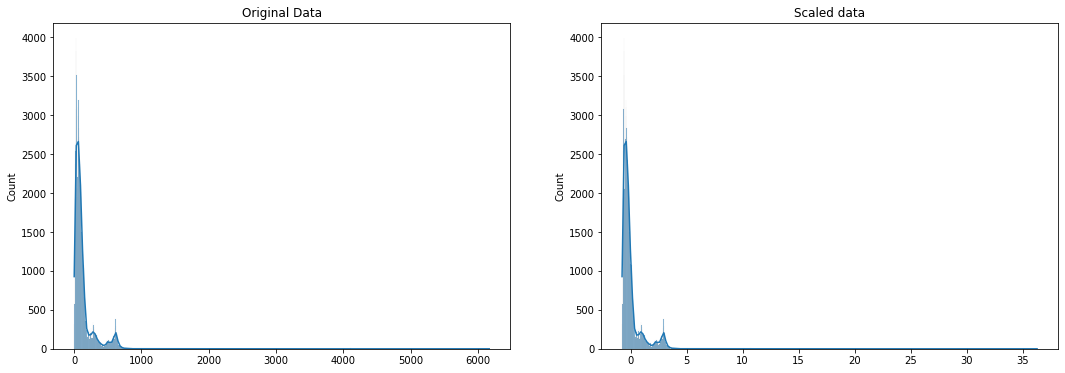

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(sampled_workload_data_df.values[:,6], ax=ax[0], kde=True, legend=False)
ax[0].set_title("Original Data")
sns.histplot(standardscaler_results[:,6], ax=ax[1], kde=True, legend=False)
ax[1].set_title("Scaled data")
plt.show()

#### MinMax Scaler

is scaling features to lie between a given minimum and maximum value, often between zero and one, or so that the maximum absolute value of each feature is scaled to unit size. This can be achieved using MinMaxScaler or MaxAbsScaler, respectively.

In [56]:
minmaxscaler = MinMaxScaler()
minmaxscaler_results = minmaxscaler.fit_transform(sampled_workload_data_df.values)

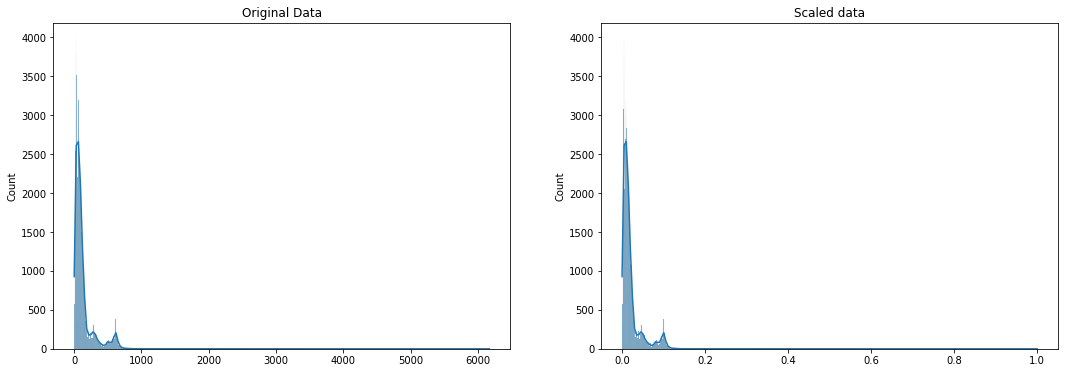

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(sampled_workload_data_df.values[:,6], ax=ax[0], kde=True, legend=False)
ax[0].set_title("Original Data")
sns.histplot(minmaxscaler_results[:,6], ax=ax[1], kde=True, legend=False)
ax[1].set_title("Scaled data")
plt.show()

#### MaxAbs Scaler

In [58]:
maxabsscaler = MaxAbsScaler()
maxabsscaler_results = maxabsscaler.fit_transform(sampled_workload_data_df.values)

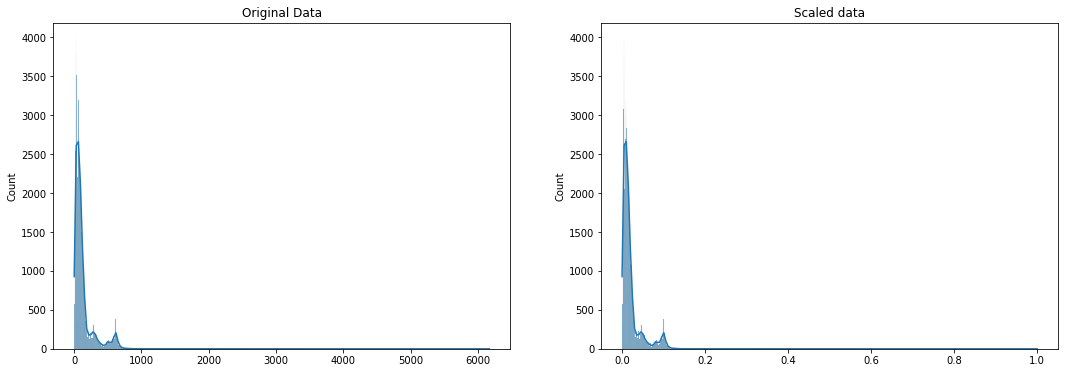

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(sampled_workload_data_df.values[:,6], ax=ax[0], kde=True, legend=False)
ax[0].set_title("Original Data")
sns.histplot(maxabsscaler_results[:,6], ax=ax[1], kde=True, legend=False)
ax[1].set_title("Scaled data")
plt.show()

#### Robust Scaler

If your data contains many outliers, scaling using the mean and variance of the data is likely to not work very well. In these cases, you can use RobustScaler as a drop-in replacement instead. It uses more robust estimates for the center and range of your data.

In [60]:
robustscaler = RobustScaler()
robustscaler_results = robustscaler.fit_transform(sampled_workload_data_df.values)

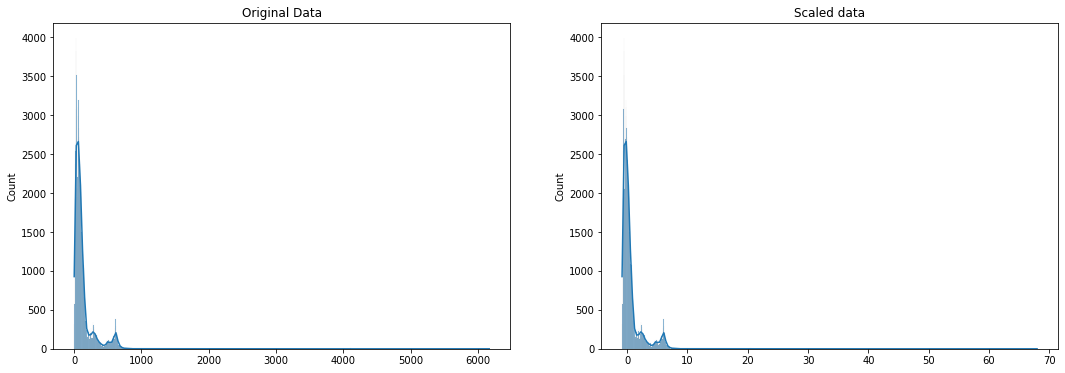

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(sampled_workload_data_df.values[:,6], ax=ax[0], kde=True, legend=False)
ax[0].set_title("Original Data")
sns.histplot(robustscaler_results[:,6], ax=ax[1], kde=True, legend=False)
ax[1].set_title("Scaled data")
plt.show()

### Normalization

#### Softmax

In [62]:
np.set_printoptions(precision=5)

In [63]:
softmax_results = softmax(sampled_workload_data_df.values, axis=0)

In [64]:
softmax_results.sum(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

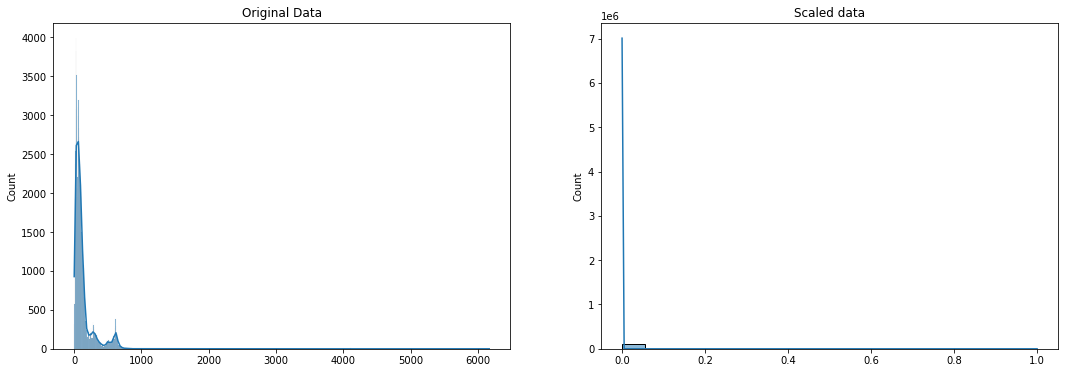

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(sampled_workload_data_df.values[:,6], ax=ax[0], kde=True, legend=False)
ax[0].set_title("Original Data")
sns.histplot(softmax_results[:,6], ax=ax[1], kde=True, legend=False)
ax[1].set_title("Scaled data")
plt.show()

#### L2 normalization

In [66]:
l2norm_results = normalize(sampled_workload_data_df.values, norm='l2')

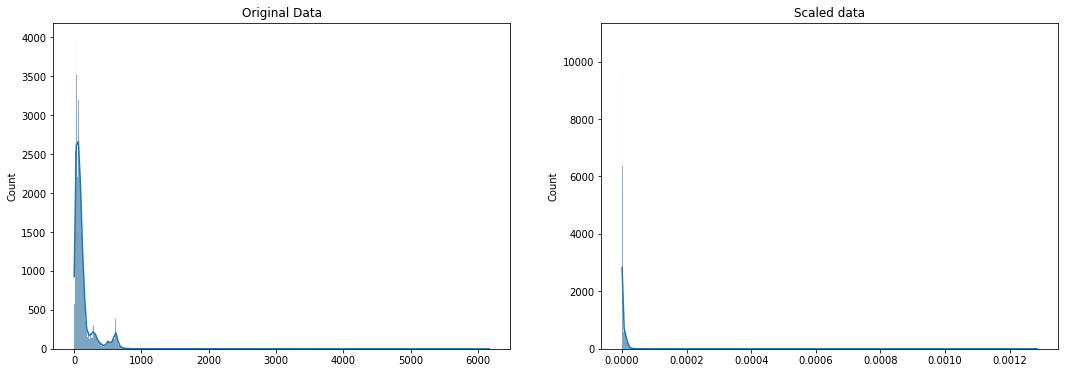

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(sampled_workload_data_df.values[:,6], ax=ax[0], kde=True, legend=False)
ax[0].set_title("Original Data")
sns.histplot(l2norm_results[:,6], ax=ax[1], kde=True, legend=False)
ax[1].set_title("Scaled data")
plt.show()

#### L1 normalization

In [68]:
l1norm_results = normalize(sampled_workload_data_df.values, norm='l1')

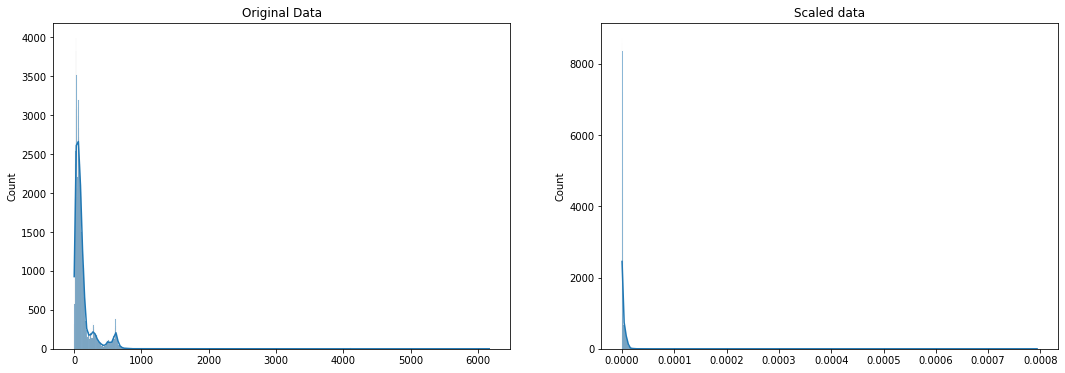

In [69]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(sampled_workload_data_df.values[:,6], ax=ax[0], kde=True, legend=False)
ax[0].set_title("Original Data")
sns.histplot(l1norm_results[:,6], ax=ax[1], kde=True, legend=False)
ax[1].set_title("Scaled data")
plt.show()

#### Max normalization

In [70]:
max_norm_results = normalize(sampled_workload_data_df.values, norm='max')

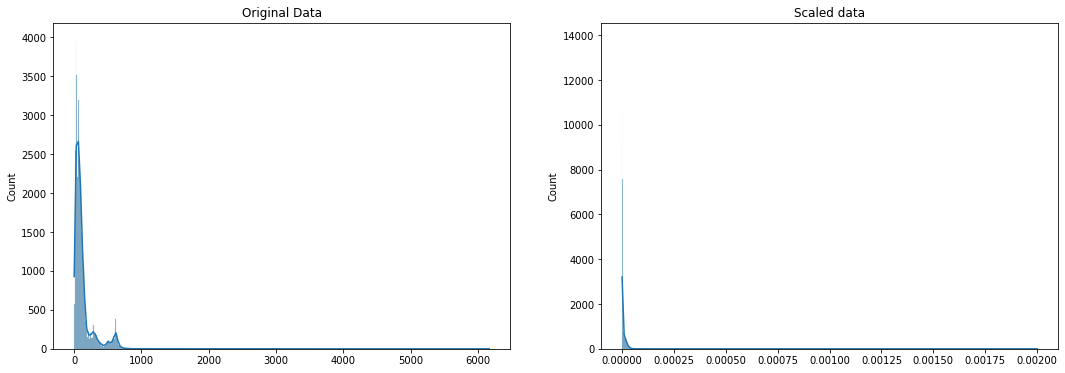

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(sampled_workload_data_df.values[:,6], ax=ax[0], kde=True, legend=False)
ax[0].set_title("Original Data")
sns.histplot(max_norm_results[:,6], ax=ax[1], kde=True, legend=False)
ax[1].set_title("Scaled data")
plt.show()

#### Yeo-Johnson power transform

In [72]:
yeojhonson_results = power_transform(sampled_workload_data_df.values, method='yeo-johnson', standardize=True)

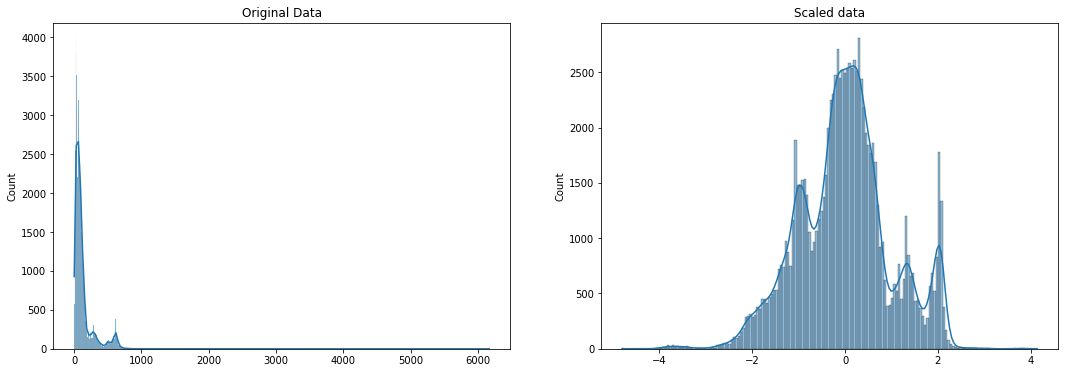

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(sampled_workload_data_df.values[:,6], ax=ax[0], kde=True, legend=False)
ax[0].set_title("Original Data")
sns.histplot(yeojhonson_results[:,6], ax=ax[1], kde=True, legend=False)
ax[1].set_title("Scaled data")
plt.show()

#### Temperature softmax

In [74]:
def temperature_softmax(x, T, axis=0):
    x_max = np.amax(x, axis=axis, keepdims=True)
    exp_x_shifted = np.exp((x - x_max) / T)
    return exp_x_shifted / np.sum(exp_x_shifted, axis=axis, keepdims=True)


In [75]:
temperature_softmax_results = temperature_softmax(sampled_workload_data_df.values, 1_000)

In [76]:
np.amax(temperature_softmax_results, axis=0)

array([2.54963e-05, 1.34515e-02, 1.91763e-02, 1.45215e-04, 1.08250e-05,
       2.17415e-05, 4.04741e-03, 1.26872e-05, 1.20303e-05, 1.20587e-05,
       1.03489e-05, 1.03470e-05, 1.00000e+00, 1.00000e+00, 9.91378e-01,
       1.00000e+00, 1.00000e+00])

In [77]:
np.amin(temperature_softmax_results, axis=0)

array([8.93103e-006, 0.00000e+000, 0.00000e+000, 5.92519e-006,
       9.82740e-006, 9.76908e-006, 8.48614e-006, 9.91051e-006,
       9.95868e-006, 9.92768e-006, 9.98861e-006, 9.97987e-006,
       0.00000e+000, 0.00000e+000, 3.55160e-043, 0.00000e+000,
       1.61186e-269])

## Generic analysis of Cluster algorithms - distances - scaling

In [78]:
min_cluster_size = [50, 100, 200, 300, 400, 600, 1_000]


In [79]:
data_transform_functions = [("standard_scaler", standardscaler.fit_transform), 
                             ("minmax_scaler", minmaxscaler.fit_transform), 
                             ("robust_scaler", robustscaler.fit_transform), 
                             ("yeo-johnson", power_transform)]

In [80]:
distance_function =['euclidean', 'manhattan']

In [ ]:
HDBSCAN_analysis = defaultdict(list)
# For each transform function (scaling or normalization)
for transform_function in data_transform_functions:
    selected_usage_normalized = transform_function[1](sampled_workload_data_df.values)
    # for every minpoints value
    for min_cl_size in min_cluster_size:
        # for every distance function
        for metric in distance_function:
            print("Processing transform_function %s - cl_size %i - metric %s" % (transform_function[0], min_cl_size, metric))
            # Compute HDBSCAN
            alg = hdbscan.HDBSCAN(min_cluster_size=min_cl_size, metric=metric)
            alg.fit_predict(selected_usage_normalized)
            # transform function
            HDBSCAN_analysis['transform_function'].append(transform_function[0])
            # metric
            HDBSCAN_analysis['metric'].append(metric)
            # cl_size
            HDBSCAN_analysis['min_cluster_size'].append(min_cl_size)
            # outliers
            HDBSCAN_analysis['n_outliers'].append(np.count_nonzero(alg.labels_ == -1))
            # n clusters
            HDBSCAN_analysis['n_clusters'].append(np.max(alg.labels_)+1)
            #mean cluster size
            HDBSCAN_analysis['mean_cluster_size'].append(np.mean([np.count_nonzero(alg.labels_ == i) for i in range(np.max(alg.labels_)+1)]))
            # avg silhouette
            if max(alg.labels_) > 0:
                silh = silhouette_samples(selected_usage_normalized, alg.labels_, metric=metric)
                mask_alg = np.array([1 if x>-1 else 0 for x in alg.labels_])
                silh_masked = silh[mask_alg.astype(bool)]
                HDBSCAN_analysis['avg_silhouette'].append(silh_masked.mean())
                
            else:
                HDBSCAN_analysis['avg_silhouette'].append(-1)
            HDBSCAN_analysis['davies_bouldin_score'].append(davies_bouldin_score(selected_usage_normalized, labels=alg.labels_))

Processing transform_function standard_scaler - cl_size 50 - metric euclidean
Processing transform_function standard_scaler - cl_size 50 - metric manhattan


In [ ]:
OPTICS_analysis = defaultdict(list)
# For each transform function (scaling or normalization)
for transform_function in data_transform_functions:
    selected_usage_normalized = transform_function[1](sampled_workload_data_df.values)
    # for every minpoints value
    for min_cl_size in min_cluster_size:
        # for every distance function
        for metric in distance_function:
            print("Processing transform_function %s - cl_size %i - metric %s" % (transform_function[0], min_cl_size, metric))
            # Compute OPTICS
            alg = OPTICS(min_samples=min_cl_size, metric=metric)
            alg.fit_predict(selected_usage_normalized)
            # transform function
            OPTICS_analysis['transform_function'].append(transform_function[0])
            # cl_size
            OPTICS_analysis['min_cluster_size'].append(min_cl_size)
            # metric
            OPTICS_analysis['metric'] = metric
            # outliers
            OPTICS_analysis['n_outliers'].append(np.count_nonzero(alg.labels_ == -1))
            # n clusters
            OPTICS_analysis['n_clusters'].append(np.max(alg.labels_)+1)
            #mean cluster size
            OPTICS_analysis['mean_cluster_size'].append(np.mean([np.count_nonzero(alg.labels_ == i) for i in range(np.max(alg.labels_)+1)]))
            # avg silhouette
            if max(alg.labels_) > 0:
                silh = silhouette_samples(selected_usage_normalized, alg.labels_, metric=metric)
                mask_alg = np.array([1 if x>-1 else 0 for x in alg.labels_])
                silh_masked = silh[mask_alg.astype(bool)]
                OPTICS_analysis['avg_silhouette'].append(silh_masked.mean())
                
            else:
                OPTICS_analysis['avg_silhouette'].append(-1)
            OPTICS_analysis['davies_bouldin_score'].append(davies_bouldin_score(selected_usage_normalized, labels=alg.labels_))

In [ ]:
x = 2

In [87]:
HDBSCAN_analysis_df = pd.DataFrame(HDBSCAN_analysis)

In [88]:
OPTICS_analysis_df = pd.DataFrame(OPTICS_analysis)

In [89]:
HDBSCAN_analysis_df

,transform_function,metric,min_cluster_size,n_outliers,n_clusters,mean_cluster_size,avg_silhouette,davies_bouldin_score
0,yeo-johnson,manhattan,50,30704,191,362.811518,0.350757,1.282518
1,yeo-johnson,manhattan,50,31130,199,346.085427,0.440876,1.266020
2,yeo-johnson,manhattan,100,35737,115,558.817391,0.387783,1.328413
3,yeo-johnson,manhattan,100,39103,124,491.112903,0.468857,1.294141
4,yeo-johnson,manhattan,200,38760,53,1155.490566,0.439505,1.445859
5,yeo-johnson,manhattan,200,45384,54,1011.425926,0.517696,1.389021
6,yeo-johnson,manhattan,300,36153,30,2128.266667,0.348775,1.528851
7,yeo-johnson,manhattan,300,42390,28,2057.535714,0.497840,1.521960
8,yeo-johnson,manhattan,400,37221,23,2729.565217,0.381708,1.732552
9,yeo-johnson,manhattan,400,44775,20,2761.300000,0.516178,1.682370


In [96]:
x = list(range(14))

HDBSCAN_analysis_df.at[index=x, "transform_function"] = "standard_scaler"

SyntaxError: invalid syntax (<ipython-input-96-41718484afe3>, line 3)

In [104]:
HDBSCAN_analysis_df['transform_function'] = [x for sublist in [[el[0]] * 14 for el in data_transform_functions] for x in sublist]

In [105]:
HDBSCAN_analysis_df

,transform_function,metric,min_cluster_size,n_outliers,n_clusters,mean_cluster_size,avg_silhouette,davies_bouldin_score
0,standard_scaler,manhattan,50,30704,191,362.811518,0.350757,1.282518
1,standard_scaler,manhattan,50,31130,199,346.085427,0.440876,1.266020
2,standard_scaler,manhattan,100,35737,115,558.817391,0.387783,1.328413
3,standard_scaler,manhattan,100,39103,124,491.112903,0.468857,1.294141
4,standard_scaler,manhattan,200,38760,53,1155.490566,0.439505,1.445859
5,standard_scaler,manhattan,200,45384,54,1011.425926,0.517696,1.389021
6,standard_scaler,manhattan,300,36153,30,2128.266667,0.348775,1.528851
7,standard_scaler,manhattan,300,42390,28,2057.535714,0.497840,1.521960
8,standard_scaler,manhattan,400,37221,23,2729.565217,0.381708,1.732552
9,standard_scaler,manhattan,400,44775,20,2761.300000,0.516178,1.682370


In [110]:
HDBSCAN_analysis_df.metric = x

In [111]:
HDBSCAN_analysis_df.tr

,transform_function,metric,min_cluster_size,n_outliers,n_clusters,mean_cluster_size,avg_silhouette,davies_bouldin_score
0,standard_scaler,euclidean,50,30704,191,362.811518,0.350757,1.282518
1,standard_scaler,manhattan,50,31130,199,346.085427,0.440876,1.266020
2,standard_scaler,euclidean,100,35737,115,558.817391,0.387783,1.328413
3,standard_scaler,manhattan,100,39103,124,491.112903,0.468857,1.294141
4,standard_scaler,euclidean,200,38760,53,1155.490566,0.439505,1.445859
5,standard_scaler,manhattan,200,45384,54,1011.425926,0.517696,1.389021
6,standard_scaler,euclidean,300,36153,30,2128.266667,0.348775,1.528851
7,standard_scaler,manhattan,300,42390,28,2057.535714,0.497840,1.521960
8,standard_scaler,euclidean,400,37221,23,2729.565217,0.381708,1.732552
9,standard_scaler,manhattan,400,44775,20,2761.300000,0.516178,1.682370


In [112]:
OPTICS_analysis_df.transform_function = [item for sublist in [[el[0]] * 14 for el in data_transform_functions] for item in sublist]

In [113]:
OPTICS_analysis_df.metric = x

In [114]:
OPTICS_analysis_df

,transform_function,min_cluster_size,metric,n_outliers,n_clusters,mean_cluster_size,avg_silhouette,davies_bouldin_score
0,standard_scaler,50,euclidean,73461,220,120.636364,0.606749,1.177118
1,standard_scaler,50,manhattan,73178,211,127.123223,0.667414,1.179520
2,standard_scaler,100,euclidean,74078,95,272.873684,0.620044,1.176741
3,standard_scaler,100,manhattan,73758,107,245.261682,0.659937,1.210046
4,standard_scaler,200,euclidean,76117,46,519.217391,0.628231,1.197653
5,standard_scaler,200,manhattan,79087,44,475.318182,0.680144,1.215231
6,standard_scaler,300,euclidean,79415,25,823.440000,0.606794,1.282315
7,standard_scaler,300,manhattan,81080,25,756.840000,0.709325,1.185139
8,standard_scaler,400,euclidean,78756,18,1180.277778,0.657939,1.401589
9,standard_scaler,400,manhattan,82145,16,1116.000000,0.676685,1.289386


### Scoring

In [115]:
def cl_size_score(optimal_cluster_size, actual_cluster_size):
    return 1 - ((abs(optimal_cluster_size - actual_cluster_size)) / max([optimal_cluster_size, actual_cluster_size]))

In [116]:
def outlier_score(n_outliers, dataset_size):
    return 1 - (n_outliers/dataset_size)

In [117]:
def weighted_scoring(scores, weights=None):
    score=0
    # if there are specifically designed weights
    if weights:
        if len(scores) != len(weights):
            print("The number of weights have to match the number of scores")
            return
        else:
            for i in range(len(scores)):
                score += scores[i] * weights[i]
    # Otherwise, we define an equal weight for each score
    else:
        weight = 1.0 / len(scores)
        for i in range(len(scores)):
            score += (scores[i] * weight)
    return score

### Score v1 - no weights

In [118]:
OPTICS_scores = []
for i in range(len(OPTICS_analysis_df)):
    experiment_scores = []
    experiment_scores.append(OPTICS_analysis_df.avg_silhouette.values[i])
    experiment_scores.append(cl_size_score(optimal_cluster_size=26, actual_cluster_size=OPTICS_analysis_df.n_clusters.values[i]))
    experiment_scores.append(outlier_score(n_outliers=OPTICS_analysis_df.n_outliers.values[i], dataset_size=100_001))
    OPTICS_scores.append(weighted_scoring(experiment_scores))
OPTICS_scores

[0.3301094754285195,
 0.35295466561321787,
 0.3843187014811324,
 0.38845173206536343,
 0.47742866527171335,
 0.4933968360793024,
 0.5913968046157404,
 0.6200238591076562,
 0.5208983427522073,
 0.49020911306501,
 0.422619455060728,
 0.39762253027614736,
 0.33839319541391527,
 0.3148660468442009,
 0.3552104855397346,
 0.3757674655394643,
 0.38963812544287224,
 0.40398579388936534,
 0.46410021274906454,
 0.45090931095422365,
 0.5350758094961235,
 0.5302258204960744,
 0.5770215030532863,
 0.56278349243467,
 0.5374178952566043,
 0.5091851516207092,
 0.45843638649600527,
 0.46539072779091534,
 0.3453605935860392,
 0.35845513857042605,
 0.3816186205389698,
 0.3957441654014984,
 0.49283816117888474,
 0.4912298775779688,
 0.5985570686623043,
 0.6259579622342634,
 0.5007666944188117,
 0.5075735508764418,
 0.4520211689919961,
 0.4216288185117619,
 0.3219324404909406,
 0.3217642943777833,
 0.32082197103101184,
 0.3396883661249141,
 0.34855031450731566,
 0.37848988810239226,
 0.504797471534274,
 0.

In [119]:
HDBSCAN_scores = []
for i in range(len(HDBSCAN_analysis_df)):
    experiment_scores = []
    experiment_scores.append(HDBSCAN_analysis_df.avg_silhouette.values[i])
    experiment_scores.append(cl_size_score(optimal_cluster_size=26, actual_cluster_size=HDBSCAN_analysis_df.n_clusters.values[i]))
    experiment_scores.append(outlier_score(n_outliers=HDBSCAN_analysis_df.n_outliers.values[i], dataset_size=100_001))
    HDBSCAN_scores.append(weighted_scoring(experiment_scores))
HDBSCAN_scores

[0.3932819420805551,
 0.42007749833325325,
 0.4188345628383249,
 0.42916946887566226,
 0.5141583186169496,
 0.5151138813266793,
 0.6179717000789462,
 0.6675052330096991,
 0.6313724105447556,
 0.612554255230623,
 0.5389088287745792,
 0.5476406231002806,
 0.49131012145134845,
 0.4864548498006986,
 0.3287906276599718,
 0.37166720744197707,
 0.36147140852863247,
 0.3787267863550903,
 0.41328689125885076,
 0.437050006654607,
 0.496705012882387,
 0.5324416994939116,
 0.5796987349678633,
 0.6333140161735286,
 0.5387059078185548,
 0.5298042318214718,
 0.4937023049938689,
 0.47517790869969984,
 0.39175312657070666,
 0.4193511761812844,
 0.44740552808014833,
 0.43779292027252104,
 0.5424779395238752,
 0.49766465336938775,
 0.6008271016266822,
 0.6241409185791857,
 0.6438307024484775,
 0.6906019316544172,
 0.49627083290178153,
 0.559118365666708,
 0.4511261210959073,
 0.44266081650058947,
 0.42697062676920944,
 0.4492052792614951,
 0.4492699524844752,
 0.466964032735874,
 0.5573919464233646,
 0.5

In [120]:
HDBSCAN_analysis_df['scores_v1'] = HDBSCAN_scores

In [121]:
OPTICS_analysis_df['scores_v1'] = OPTICS_scores

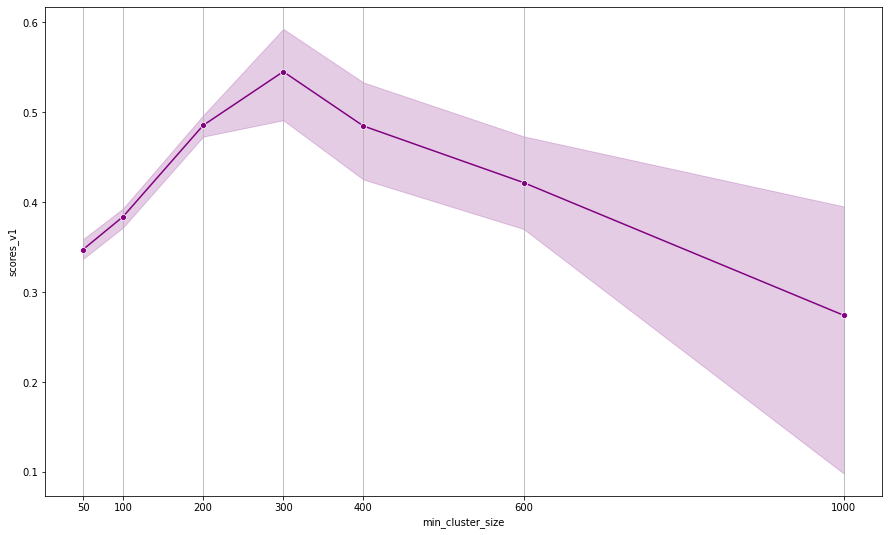

In [132]:
plt.figure(figsize=(15,9))
sns.lineplot(x=OPTICS_analysis_df.min_cluster_size, y=OPTICS_analysis_df.scores_v1, color="purple", linestyle="-", marker="o")
#for x, y in zip(OPTICS_analysis_df.min_cluster_size, OPTICS_analysis_df.scores_v1):
#    plt.text(x = x, y = y, s = '{:.0f}'.format(x))

plt.xticks(min_cluster_size, min_cluster_size)
plt.grid(axis='x')

In [136]:
OPTICS_analysis_df.loc[OPTICS_analysis_df.scores_v1.idxmax()]

transform_function      robust_scaler
min_cluster_size                  300
metric                      manhattan
n_outliers                      78782
n_clusters                         26
mean_cluster_size          816.115385
avg_silhouette               0.665686
davies_bouldin_score         1.282082
scores_v1                    0.625958
Name: 35, dtype: object

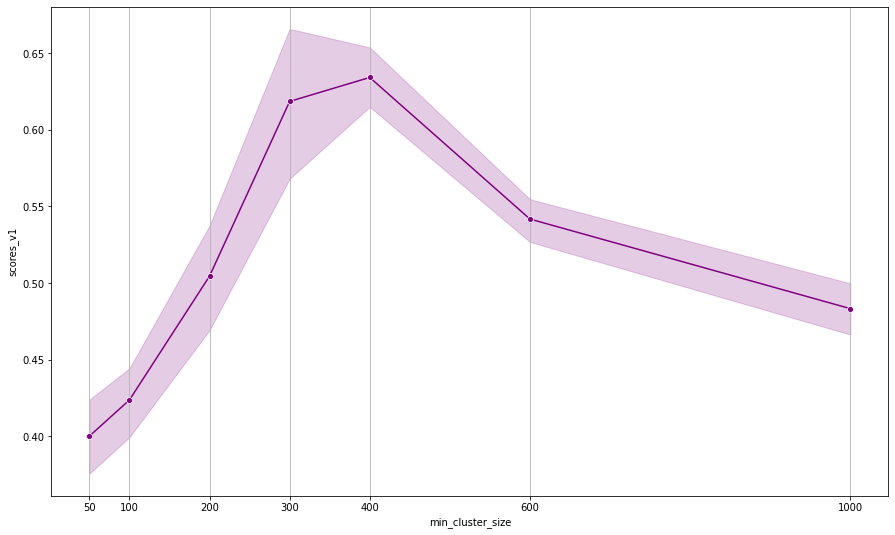

In [133]:
plt.figure(figsize=(15,9))
sns.lineplot(x=HDBSCAN_analysis_df.min_cluster_size, y=HDBSCAN_analysis_df.scores_v1, color="purple", linestyle="-", marker="o")
#for x, y in zip(HDBSCAN_analysis_df.min_cluster_size, HDBSCAN_analysis_df.scores_v1):
#    plt.text(x = x, y = y, s = '{:.0f}'.format(x))
plt.xticks(min_cluster_size, min_cluster_size)
plt.grid(axis='x')

In [135]:
HDBSCAN_analysis_df.loc[HDBSCAN_analysis_df.scores_v1.idxmax()]

transform_function      yeo-johnson
metric                    euclidean
min_cluster_size                300
n_outliers                    24603
n_clusters                       26
mean_cluster_size       2899.923077
avg_silhouette             0.399382
davies_bouldin_score       1.482217
scores_v1                  0.717785
Name: 48, dtype: object

### Score v3 - silh_score 0.4, n_clusters_score 0.1, n_outliers_score 0.5

In [137]:
OPTICS_scores_v3 = []
for i in range(len(OPTICS_analysis_df)):
    experiment_scores = []
    experiment_scores.append(OPTICS_analysis_df.avg_silhouette.values[i])
    experiment_scores.append(cl_size_score(optimal_cluster_size=26, actual_cluster_size=OPTICS_analysis_df.n_clusters.values[i]))
    experiment_scores.append(outlier_score(n_outliers=OPTICS_analysis_df.n_outliers.values[i], dataset_size=100_001))
    OPTICS_scores_v3.append(weighted_scoring(experiment_scores, [0.4, 0.1, 0.5]))
OPTICS_scores_v3

[0.3872165596623319,
 0.413401505863994,
 0.40499991939205654,
 0.4194876197893782,
 0.4272329420971401,
 0.43571726688452705,
 0.4418004212194086,
 0.4744879032595412,
 0.4386304911624656,
 0.42149137250441304,
 0.3961321100313879,
 0.38722274326661515,
 0.3547178864977168,
 0.34250530186027695,
 0.43047796474810407,
 0.4548903174500097,
 0.4418353387708161,
 0.4658308395567906,
 0.468379066083904,
 0.4626715737794183,
 0.48729735654079914,
 0.47647943965359574,
 0.4798179297426827,
 0.4773367995269464,
 0.4583489552177315,
 0.44168364456099424,
 0.45716982410283413,
 0.4623720650864119,
 0.40839675932944347,
 0.42397243350129116,
 0.4073834972940609,
 0.42650384086394044,
 0.4336118713538824,
 0.4325949219028746,
 0.4576442424833181,
 0.4723683424932379,
 0.4294535171985044,
 0.4278152660893722,
 0.40505027654165787,
 0.3904133914721756,
 0.3325740044999081,
 0.33163723651404586,
 0.38397606571677856,
 0.40342235986770447,
 0.3673154297153986,
 0.4227673250895674,
 0.3880251431593557

In [138]:
HDBSCAN_scores_v3 = []
for i in range(len(HDBSCAN_analysis_df)):
    experiment_scores = []
    experiment_scores.append(HDBSCAN_analysis_df.avg_silhouette.values[i])
    experiment_scores.append(cl_size_score(optimal_cluster_size=26, actual_cluster_size=HDBSCAN_analysis_df.n_clusters.values[i]))
    experiment_scores.append(outlier_score(n_outliers=HDBSCAN_analysis_df.n_outliers.values[i], dataset_size=100_001))
    HDBSCAN_scores_v3.append(weighted_scoring(experiment_scores, [0.4, 0.1, 0.5]))
HDBSCAN_scores_v3

[0.5003969411985172,
 0.5337673293972935,
 0.49903874581589447,
 0.5129975278704328,
 0.5310605586157089,
 0.5283086669830324,
 0.5454134016211202,
 0.5800452749359715,
 0.5550416494753693,
 0.5595213232530395,
 0.5217176134900747,
 0.5218758698798844,
 0.4915456260068155,
 0.4761113961050749,
 0.42676499405476764,
 0.47584026411446756,
 0.43416657685049287,
 0.4568884503982924,
 0.44448736741297523,
 0.4723250698754502,
 0.47366173930162603,
 0.5000296235188039,
 0.49871203187109825,
 0.5279089258014561,
 0.465248362907992,
 0.47975983054593496,
 0.46923592113801443,
 0.478521061210086,
 0.4989050313139142,
 0.5338557300743548,
 0.5216120364421506,
 0.5209306745857429,
 0.5424995057858881,
 0.5323911574806652,
 0.5569597908507582,
 0.5671589203968419,
 0.5580687813222376,
 0.5775828293801868,
 0.4735545653403255,
 0.5202697378307517,
 0.44667836896792923,
 0.45823394016033464,
 0.5566247732909556,
 0.5831298343709674,
 0.5506799534716855,
 0.573408084770594,
 0.5865898932063403,
 0.59

In [139]:
HDBSCAN_analysis_df['scores_v3'] = HDBSCAN_scores_v3

In [140]:
OPTICS_analysis_df['scores_v3'] = OPTICS_scores_v3

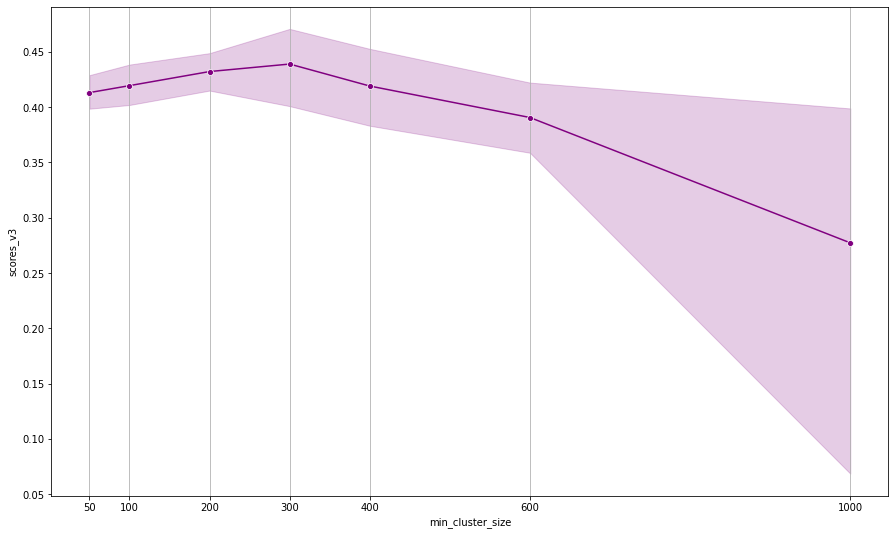

In [141]:
plt.figure(figsize=(15,9))
sns.lineplot(x=OPTICS_analysis_df.min_cluster_size, y=OPTICS_analysis_df.scores_v3, color="purple", linestyle="-", marker="o")

plt.xticks(min_cluster_size, min_cluster_size)
plt.grid(axis='x')

In [145]:
OPTICS_analysis_df.loc[OPTICS_analysis_df.scores_v3.idxmax()]

transform_function      minmax_scaler
min_cluster_size                  300
metric                      euclidean
n_outliers                      73399
n_clusters                         43
mean_cluster_size          618.651163
avg_silhouette               0.734559
davies_bouldin_score         1.133123
scores_v1                    0.535076
scores_v3                    0.487297
Name: 20, dtype: object

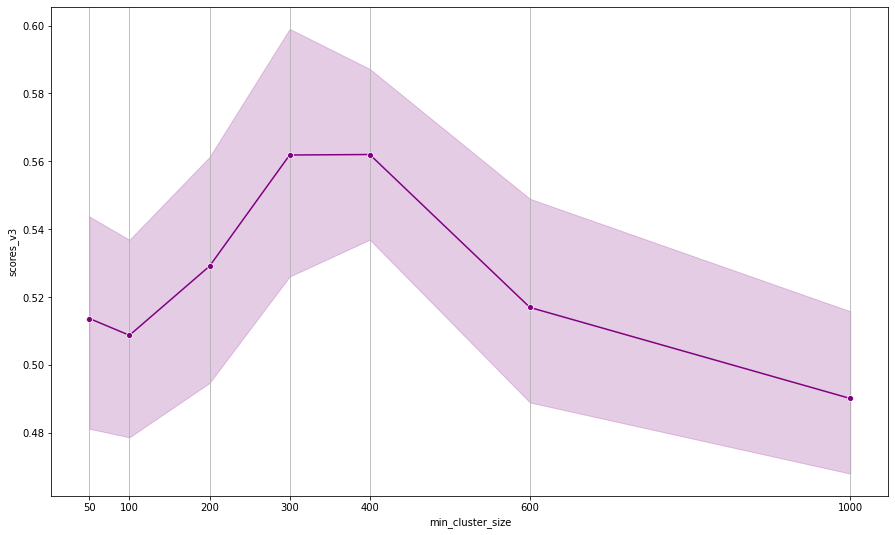

In [143]:
plt.figure(figsize=(15,9))
sns.lineplot(x=HDBSCAN_analysis_df.min_cluster_size, y=HDBSCAN_analysis_df.scores_v3, color="purple", linestyle="-", marker="o")

plt.xticks(min_cluster_size, min_cluster_size)
plt.grid(axis='x')

In [142]:
HDBSCAN_analysis_df.loc[HDBSCAN_analysis_df.scores_v3.idxmax()]

transform_function      yeo-johnson
metric                    euclidean
min_cluster_size                300
n_outliers                    24603
n_clusters                       26
mean_cluster_size       2899.923077
avg_silhouette             0.399382
davies_bouldin_score       1.482217
scores_v1                  0.717785
scores_v3                  0.636739
Name: 48, dtype: object

In [147]:
HDBSCAN_analysis_df['CCPM'] = HDBSCAN_analysis_df.avg_silhouette + (1 / HDBSCAN_analysis_df.davies_bouldin_score)

In [208]:
OPTICS_analysis_df['CCPM'] = OPTICS_analysis_df.avg_silhouette + (1 / OPTICS_analysis_df.davies_bouldin_score)

In [154]:
HDBSCAN_analysis_df.loc[HDBSCAN_analysis_df.CCPM.idxmax()]

transform_function      yeo-johnson
metric                    manhattan
min_cluster_size                100
n_outliers                    24549
n_clusters                      125
mean_cluster_size           603.616
avg_silhouette              0.43838
davies_bouldin_score       1.195339
scores_v1                  0.466964
scores_v3                  0.573408
CCPM                       1.274962
Name: 45, dtype: object

In [209]:
HDBSCAN_analysis_df.to_csv('experiments/01_hdbscan_analysis.csv')
OPTICS_analysis_df.to_csv('experiments/01_optics_analysis.csv')

In [162]:
import math

In [163]:
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

In [177]:
(cl_size_score(26, 3_000), np.tanh(cl_size_score(26, 3_000)))

(0.008666666666666711, 0.008666449685531465)

In [178]:
cl_size_score_df = pd.DataFrame({'base': [cl_size_score(26, x) for x in range(5_000)], 'tanh': [np.tanh(cl_size_score(26, x)) for x in range(5_000)]})

(0.0, 100.0)

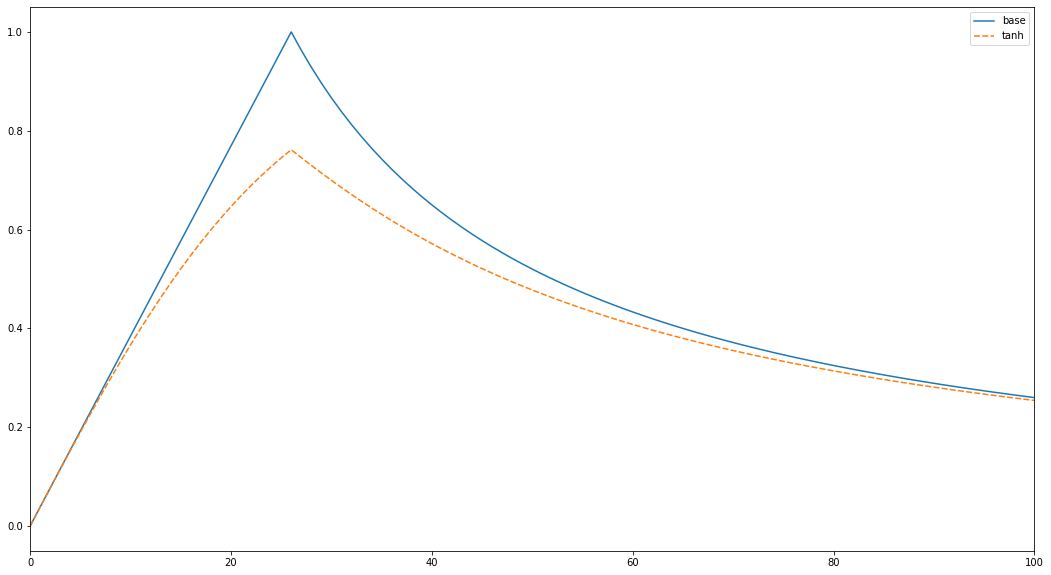

In [183]:

plt.figure(figsize=(18,10))
sns.lineplot(data=cl_size_score_df)
plt.xlim((0, 100))

## Best approach

In [184]:
scaled_values = power_transform(sampled_workload_data_df.values)

In [185]:
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=300, metric='euclidean')

In [186]:
hdbscan_clusterer.fit_predict(scaled_values)

array([ 9,  9,  0, ...,  9, -1, -1])

(4.0, 0.0)

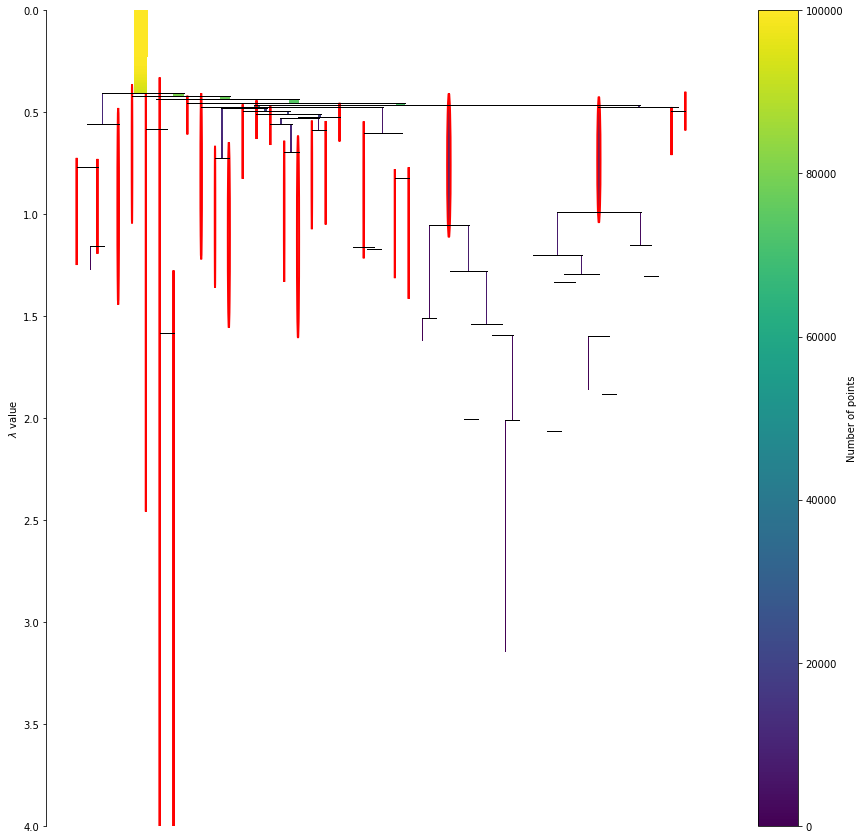

In [187]:
plt.figure(figsize=(15, 15))


hdbscan_clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

plt.ylim(4, 0)

### Compute silhouette

In [188]:
silhouette_HDBSCAN = silhouette_samples(scaled_values, hdbscan_clusterer.labels_, metric='euclidean')

In [189]:
mask = np.array([1 if x>-1 else 0 for x in hdbscan_clusterer.labels_])
mask

array([1, 1, 1, ..., 1, 0, 0])

In [190]:
silhouette_masked = silhouette_HDBSCAN[mask.astype(bool)]

In [191]:
silhouette_masked.mean()

0.3993821582528378

In [192]:
silhouette_HDBSCAN

array([ 0.43213,  0.46001,  0.5014 , ...,  0.26454, -0.38508, -0.27056])

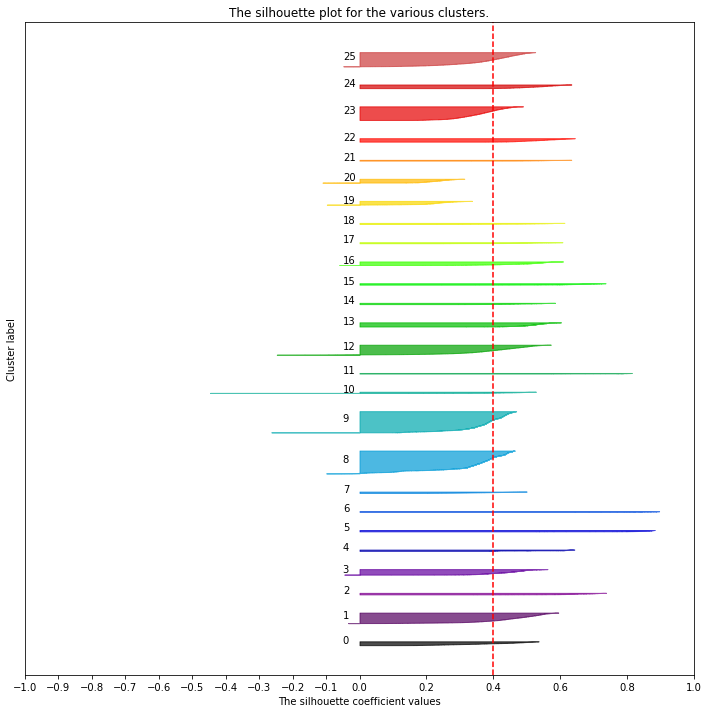

In [193]:
plot_silhouette_results(hdbscan_clusterer.labels_, silhouette_masked.mean(), silhouette_HDBSCAN, max(hdbscan_clusterer.labels_) + 1, multiplier=10000)

## Classification

In [195]:
sampled_workload_data.columns

Index(['index', 'job_name', 'inst_id', 'user', 'task_name', 'inst_num',
       'status', 'start_time', 'end_time', 'plan_cpu', 'plan_mem', 'plan_gpu',
       'gpu_type', 'group', 'workload', 'inst_name', 'worker_name', 'machine',
       'gpu_name', 'cpu_usage', 'gpu_wrk_util', 'avg_mem', 'max_mem',
       'avg_gpu_wrk_mem', 'max_gpu_wrk_mem', 'read', 'write', 'read_count',
       'write_count', 'duration'],
      dtype='object')

In [240]:
hdbscan_clustered_data = sampled_workload_data[['job_name', 'inst_id', 'user', 'task_name', 'group', 'workload', 'worker_name']].values[mask.astype(bool)]

In [245]:
hdbscan_notnoise_labels = hdbscan_clusterer.labels_[mask.astype(bool)]

In [241]:
onehot_enc = OneHotEncoder(sparse=True).fit(hdbscan_clustered_data)

sampled_onehotencoded_data = onehot_enc.transform(hdbscan_clustered_data)

In [242]:
sampled_onehotencoded_data

<75398x88219 sparse matrix of type '<class 'numpy.float64'>'
	with 527786 stored elements in Compressed Sparse Row format>

In [243]:
encoded_feature_names = onehot_enc.get_feature_names(['job_name', 'inst_id', 'user', 'task_name', 'group', 'workload', 'worker_name'])

In [265]:
encoded_feature_names.shape

(88219,)

### XGBoost

In [250]:
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

In [247]:
X_train, X_test, y_train, y_test = train_test_split(sampled_onehotencoded_data, hdbscan_notnoise_labels, test_size=0.20, random_state=5)

In [248]:
(X_train.shape, X_test.shape)

((60318, 88219), (15080, 88219))

In [251]:
model = XGBClassifier() 

model.fit(X_train, y_train)

/opt/anaconda3/envs/neuralnets/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:57:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=80,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [252]:
y_pred = model.predict(X_test) 

predictions = [round(value) for value in y_pred]

In [253]:
accuracy = accuracy_score(y_test, predictions) 

print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 95.15%


In [267]:
model.get_booster().feature_names = list(encoded_feature_names)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

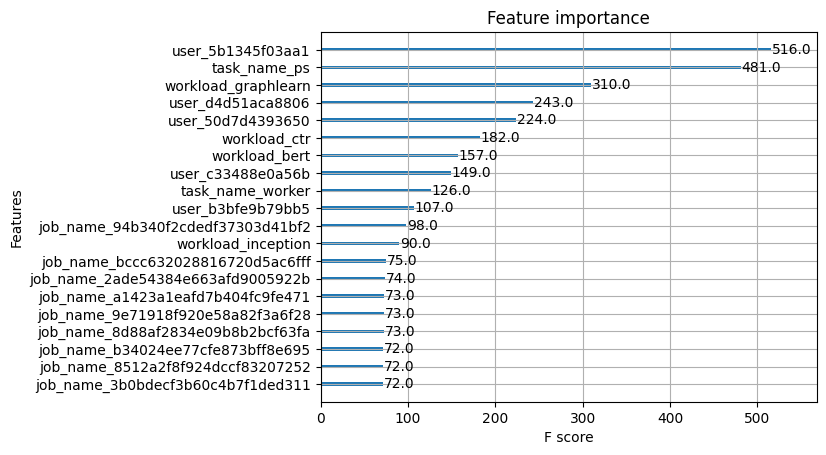

In [268]:
from xgboost import plot_importance

plot_importance(model, max_num_features=20)

In [269]:
from xgboost import to_graphviz

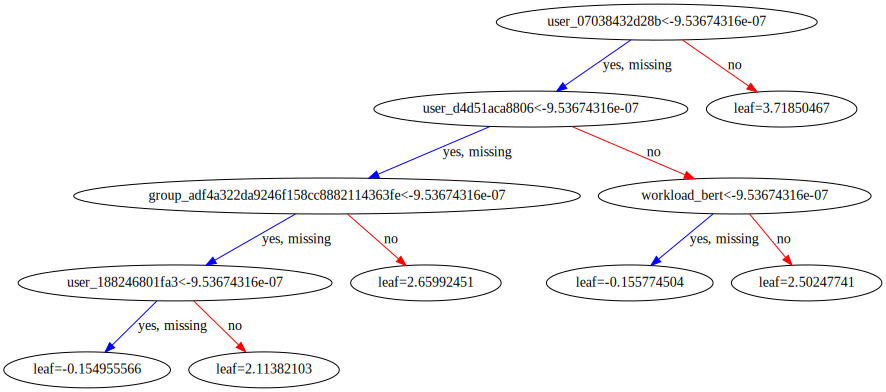

In [270]:
to_graphviz(model)

In [271]:
from sklearn.metrics import classification_report,confusion_matrix

In [272]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.90      1.00      0.94       415
           1       0.99      1.00      1.00      1172
           2       1.00      1.00      1.00       177
           3       1.00      0.99      0.99       607
           4       1.00      1.00      1.00       143
           5       0.66      1.00      0.80       134
           6       0.00      0.00      0.00        68
           7       0.94      0.99      0.96       134
           8       1.00      0.98      0.99      2509
           9       1.00      1.00      1.00      2316
          10       1.00      0.98      0.99       128
          11       1.00      1.00      1.00        64
          12       1.00      1.00      1.00      1104
          13       1.00      1.00      1.00       468
          14       1.00      1.00      1.00       135
          15       1.00      0.99      0.99       158
          16       0.99      1.00      1.00       370
          17       1.00    

/opt/anaconda3/envs/neuralnets/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  -----
/opt/anaconda3/envs/neuralnets/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  -----
/opt/anaconda3/envs/neuralnets/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  -----


In [278]:
import shap

ImportError: cannot import name '_mode' from 'sklearn.utils.fixes' (/opt/anaconda3/envs/neuralnets/lib/python3.8/site-packages/sklearn/utils/fixes.py)

In [280]:
sampled_workload_data.to_csv('experiments/100_001_sampled_workload_data.csv')

In [281]:
import pickle

pickle.dump(hdbscan_clusterer, open("experiments/hdbscan_300_power_transform_euclidean.pkl", "wb"))